<a href="https://colab.research.google.com/github/binliu0630/TimeSeries/blob/main/TimeSeries_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from numpy import mean, std
import matplotlib.pyplot as plt

## DATA PREP

In [2]:
#data = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')
data = pd.read_csv('https://raw.githubusercontent.com/gumdropsteve/datasets/master/yellow_cab_ymd_averages.csv', usecols=['ds', 'avg_trip_distance'])
data.sample(5)

,ds,avg_trip_distance
1729,2013-9-26,2.981019
1428,2012-11-29,2.787307
2872,2016-11-11 00:00:00,2.881498
3886,2019-08-22 00:00:00,3.018909
3742,2019-03-31 00:00:00,3.261136


In [3]:
# make sure the columns names/datatype: ds(datetime) and y(float)

data.rename(columns={'avg_trip_distance': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])
data['y'] = data['y'].astype('float')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4018 non-null   datetime64[ns]
 1   y       4018 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.9 KB


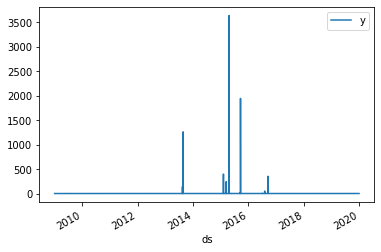

In [4]:
data.plot(x='ds', y='y')

In [5]:
# remove the ourlier data points. 
# More approach@https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
# Standard Deviation Method

# calculate summary statistics
y_mean, y_std = mean(data['y']), std(data['y'])
# identify outliers
cut_off = y_std
lower, upper = y_mean - cut_off, y_mean + cut_off
# identify outliers
outliers = [x for x in data['y'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
# remove outliers in the df
outliers_removed = [x for x in data['y'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Identified outliers: 7
Non-outlier observations: 4011


In [6]:
upper

73.51909149440561

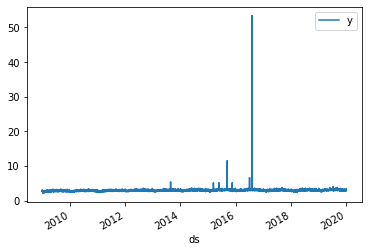

In [7]:
data[data['y'] < upper].plot(x='ds', y='y')

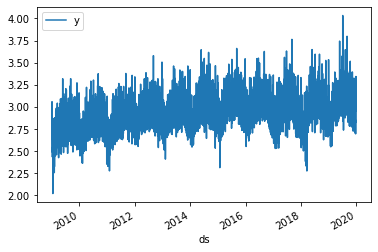

In [8]:
# eventually to settle with remove anything higher than the mean and the chart looks more reseaonable
data = data[data['y'] < y_mean]
data.plot(x='ds', y='y')

## Model

In [9]:
%%capture
!pip install pystan==2.19.1.1

!pip install prophet

In [10]:
from prophet import Prophet

In [11]:
# initial Prophet model: remove daily seasonality
model = Prophet(daily_seasonality=False)
# add holiday
model.add_country_holidays(country_name='US')
# fit the model
model.fit(data)

## Forecasting

In [12]:
future = model.make_future_dataframe(periods=365, freq='D')

In [13]:
future.tail()

,ds
4364,2020-12-26
4365,2020-12-27
4366,2020-12-28
4367,2020-12-29
4368,2020-12-30


In [14]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-01-01,2.694800,2.836163,3.100942,2.694800,2.694800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383634,0.383634,0.383634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278444,0.278444,0.278444,0.383634,0.383634,0.383634,-0.040521,-0.040521,-0.040521,-0.064668,-0.064668,-0.064668,0.0,0.0,0.0,2.973244
1,2009-01-02,2.694899,2.462019,2.718996,2.694899,2.694899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.105717,-0.105717,-0.105717,0.000000,0.000000,0.000000,-0.037043,-0.037043,-0.037043,-0.068674,-0.068674,-0.068674,0.0,0.0,0.0,2.589182
2,2009-01-03,2.694999,2.416774,2.686745,2.694999,2.694999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.142242,-0.142242,-0.142242,0.000000,0.000000,0.000000,-0.069131,-0.069131,-0.069131,-0.073111,-0.073111,-0.073111,0.0,0.0,0.0,2.552757
3,2009-01-04,2.695099,2.752653,3.010255,2.695099,2.695099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185678,0.185678,0.185678,0.000000,0.000000,0.000000,0.263642,0.263642,0.263642,-0.077964,-0.077964,-0.077964,0.0,0.0,0.0,2.880777
4,2009-01-05,2.695199,2.546322,2.815263,2.695199,2.695199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019064,-0.019064,-0.019064,0.000000,0.000000,0.000000,0.064141,0.064141,0.064141,-0.083205,-0.083205,-0.083205,0.0,0.0,0.0,2.676135


In [15]:
forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].tail()

,ds,yhat_lower,yhat,yhat_upper
4364,2020-12-26,2.839472,2.977252,3.111475
4365,2020-12-27,3.169347,3.308689,3.442623
4366,2020-12-28,2.976138,3.107482,3.238022
4367,2020-12-29,2.816041,2.948728,3.086007
4368,2020-12-30,2.812612,2.950129,3.078715


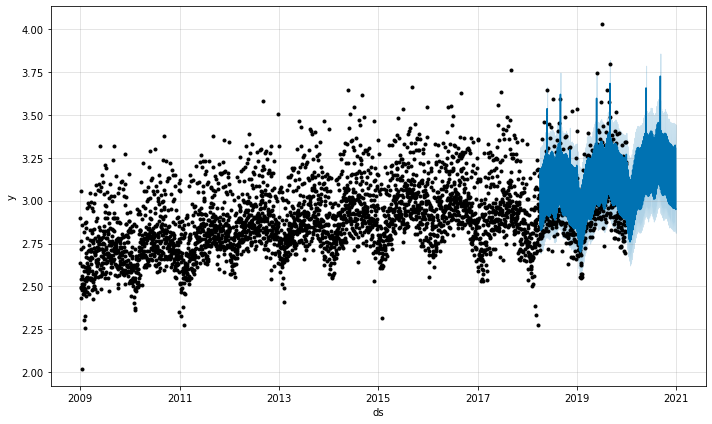

In [16]:
model.plot(forecast.tail(1000))
plt.show()

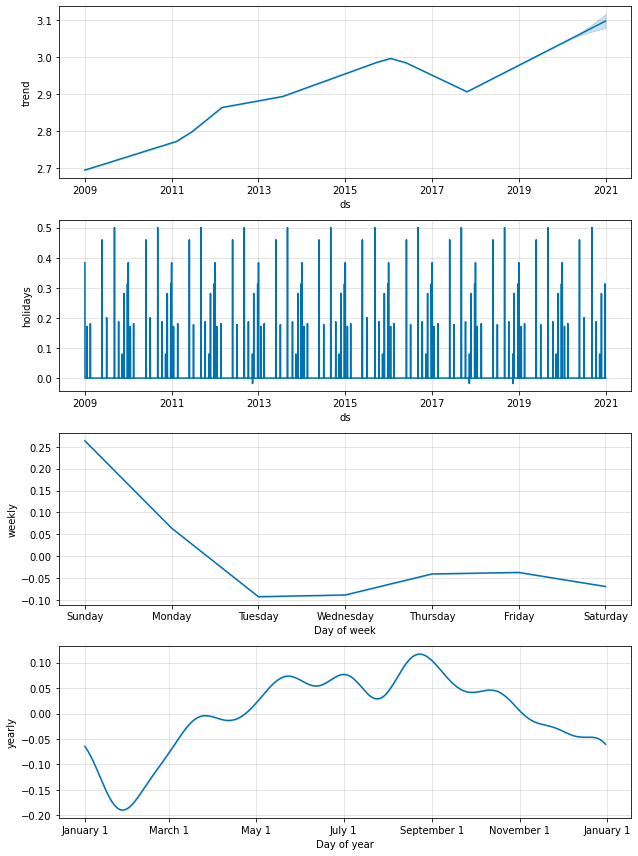

In [17]:
model.plot_components(forecast)
plt.show()

In [18]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [19]:
# Python
plot_components_plotly(model, forecast)


## Cross Validation

In [29]:
from prophet.diagnostics import cross_validation, performance_metrics

In [28]:
%%time
cv = cross_validation(model, 
                         horizon="365 days",
                         period="182.5 days", 
                         initial="730 days", 
                         parallel=None
                        )

INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



CPU times: user 1min 15s, sys: 44.1 s, total: 1min 59s
Wall time: 1min 11s


In [30]:
cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-01-03,2.769629,2.656038,2.881176,2.875597,2011-01-02
1,2011-01-04,2.634589,2.525575,2.747228,2.702161,2011-01-02
2,2011-01-05,2.633945,2.525101,2.748019,2.760372,2011-01-02
3,2011-01-06,2.665264,2.553500,2.776318,2.521935,2011-01-02
4,2011-01-07,2.669167,2.548939,2.787329,2.516577,2011-01-02
...,...,...,...,...,...,...
6174,2019-12-27,2.837882,2.711789,2.973827,3.152521,2018-12-31
6175,2019-12-28,2.806689,2.676574,2.941114,3.223464,2018-12-31
6176,2019-12-29,3.133118,3.011066,3.259506,3.342982,2018-12-31
6177,2019-12-30,2.927751,2.808696,3.063891,2.992685,2018-12-31


In [33]:
performance_metrics(cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,0.014638,0.120989,0.0932,0.031744,0.02603,0.031714,0.709338


## Hyper Prameter Search

In [42]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # store the mape for each pa

In [43]:
all_params[0:2]

[{'changepoint_prior_scale': 0.001,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 0.01}]

In [44]:
# Use cross validation to evaluate all parameters
for i in range(len(all_params)):
    print(f'cross validating param set {i} / {len(all_params) - 1}')
    # create & fit model with given params combo
    m = Prophet(daily_seasonality=False, **all_params[i]).fit(data)
    # cross validate the model 
    cv = cross_validation(m, 
                             horizon="365 days",
                             period="182.5 days", 
                             initial="730 days", 
                             parallel=None)
    
    perf = performance_metrics(cv, rolling_window=1)
    # pull rmse and add it to the list
    mapes.append(perf['mape'].values[0])

cross validating param set 0 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 1 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 2 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 3 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 4 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 5 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 6 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 7 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 8 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 9 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 10 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 11 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 12 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 13 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 14 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 15 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 16 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 17 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 18 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 19 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 20 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 21 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 22 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 23 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 24 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 25 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 26 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 27 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 28 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 29 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 30 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00



cross validating param set 31 / 31


INFO:prophet:Making 17 forecasts with cutoffs between 2011-01-02 00:00:00 and 2018-12-31 00:00:00


In [45]:
mapes

[0.03320942500702565,
 0.033092326357746484,
 0.033299642693701274,
 0.03326079442681665,
 0.033233630381812124,
 0.03308828177760284,
 0.03330233002463027,
 0.03318946852809517,
 0.032652509234822935,
 0.03249046378233674,
 0.03265302747846592,
 0.032521431265434025,
 0.032668433931020244,
 0.03250034931144521,
 0.03272535079475448,
 0.03251443806479691,
 0.03311774561112254,
 0.03290198775915639,
 0.03311232674521245,
 0.03293088394964991,
 0.03314188070893512,
 0.032960478949625935,
 0.0330953737894166,
 0.03299968741777709,
 0.03545882553450163,
 0.03731878978505231,
 0.03330035050178402,
 0.03486176004808804,
 0.0334534839434964,
 0.034431604524513305,
 0.03380496615380454,
 0.03454533807544583]

## Get the Best Model

In [46]:
import numpy as np

# pull the highest scoring param combo
best_params = all_params[np.argmin(mapes)]

best_params

{'changepoint_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}

In [48]:
best_model = Prophet(daily_seasonality=False, **best_params).fit(data)
future = best_model.make_future_dataframe(periods=365)
forecast = best_model.predict(future)

In [49]:
plot_plotly(best_model, forecast)

In [50]:
plot_components_plotly(best_model, forecast)